# 모델 불러오기

In [1]:

import onnx

# 모델 로드
model = onnx.load("models/image_clip.onnx")

# 노드 타입 확인
node_types = [node.op_type for node in model.graph.node]

# 양자화 관련 연산자 목록
quant_ops = {"QuantizeLinear", "DequantizeLinear", "QLinearConv", "QLinearMatMul", "QLinearAdd"}

# 양자화 여부 확인
quantized = any(op in node_types for op in quant_ops)

print("양자화 여부:", "✅ 양자화됨" if quantized else "❌ 양자화되지 않음")

# 참고로 어떤 연산이 들어있는지도 출력할 수 있음
print("포함된 연산 종류:", set(node_types))

양자화 여부: ❌ 양자화되지 않음
포함된 연산 종류: {'Concat', 'Mul', 'Conv', 'MatMul', 'Gather', 'Equal', 'Softmax', 'Unsqueeze', 'Sub', 'Slice', 'Add', 'Cast', 'Sigmoid', 'Reshape', 'Transpose', 'Shape', 'Where', 'ReduceMean', 'Sqrt', 'Expand', 'Pow', 'ConstantOfShape', 'Div', 'Constant'}


In [3]:
import onnxruntime as ort

# ONNX 모델 로드 (경로 수정 필요)
session = ort.InferenceSession("models/image_clip.onnx", providers=["CPUExecutionProvider"])

# 입력 이름 확인 (모델마다 다를 수 있음)
input_name = session.get_inputs()[0].name
print("Input name:", input_name)


Input name: pixel_values


https://www.kaggle.com/code/ivanpan/pytorch-clip-onnx-to-speed-up-inference

In [4]:
for input in session.get_inputs():
    print("입력 이름:", input.name, "| 타입:", input.type)

입력 이름: pixel_values | 타입: tensor(float)


## 이미지 전처리 함수 (uint8 유지, 정규화 x)

In [5]:
import numpy as np
from PIL import Image
def preprocess_image(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0          # [0, 1]
    img_np = (img_np - 0.5) / 0.5                               # [-1, 1]
    img_np = np.transpose(img_np, (2, 0, 1))                    # (HWC) → (CHW)
    img_np = np.expand_dims(img_np, axis=0)                    # (1, C, H, W)
    return img_np

## CLIP 임베딩 추출 함수

In [6]:
# 3. CLIP 임베딩 추출 함수
def get_clip_embedding(img_tensor):
    output = session.run(None, {input_name: img_tensor})
    return output[0].squeeze()  # shape: (512,) or (1024,)

## 이미지 데이터 셋 로드

In [7]:
import os
print("현재 작업 디렉토리:", os.getcwd())
print("존재 여부:", os.path.exists("real_furniture_image_set"))

현재 작업 디렉토리: c:\Users\hnn07\Documents\clip_embeddings
존재 여부: True


In [8]:
import os
import glob
IMAGE_DIR = "real_furniture_image_set/"

image_paths = []
labels = []

for class_dir in os.listdir(IMAGE_DIR):
    class_path = os.path.join(IMAGE_DIR, class_dir)
    if not os.path.isdir(class_path):
        continue

    for img_path in glob.glob(os.path.join(class_path, "*.*")):
        image_paths.append(img_path)
        labels.append(class_dir)  # 폴더 이름이 곧 클래스 이름

## 임베딩 추출 함수

In [9]:
def get_clip_embedding(img_tensor):
    output = session.run(None, {input_name: img_tensor})
    return output[0].squeeze()  # (512,) 또는 (1024,)


## 이미지별 임베딩 추출

In [10]:
# 4. 임베딩 추출
embeddings = []
labels = []

for path in image_paths:
    try:
        img = preprocess_image(path)
        ort_inputs = {input_name: img}
        ort_outs = session.run(None, ort_inputs)[0]  # shape: (1, 50, 768) or (1, 768)
        emb = ort_outs.squeeze()  # shape: (50, 768) or (768,)
        
        # 평균 벡터로 압축 (if patch-wise)
        if len(emb.shape) == 2:
            emb = emb.mean(axis=0)

        embeddings.append(emb)
        labels.append(os.path.basename(os.path.dirname(path)))  # 폴더명을 라벨로
    except Exception as e:
        print(f"[ERROR] {path}: {e}")

In [11]:
embeddings = np.array(embeddings)
print(embeddings.shape) # 이미지 수 / 이미지당 feature 수 / 각 feature의 차원 수

(7096, 768)


## 평균 풀링 사용

In [12]:
from sklearn.preprocessing import normalize

# ✅ 1. L2 정규화 (코사인 유사도 기반 거리 개선)
normalized_embeddings = normalize(embeddings)  # shape: (7498, 768)

## 한글 폰트 설정

In [13]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

# ✅ 시스템에 설치된 한글 폰트 중 하나를 설정
# 예: 맑은 고딕 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'

# ✅ 마이너스 부호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

C:\Users\hnn07\AppData\Local\Temp\ipykernel_13296\2664592509.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels))  # 정확한 색상 수 지정


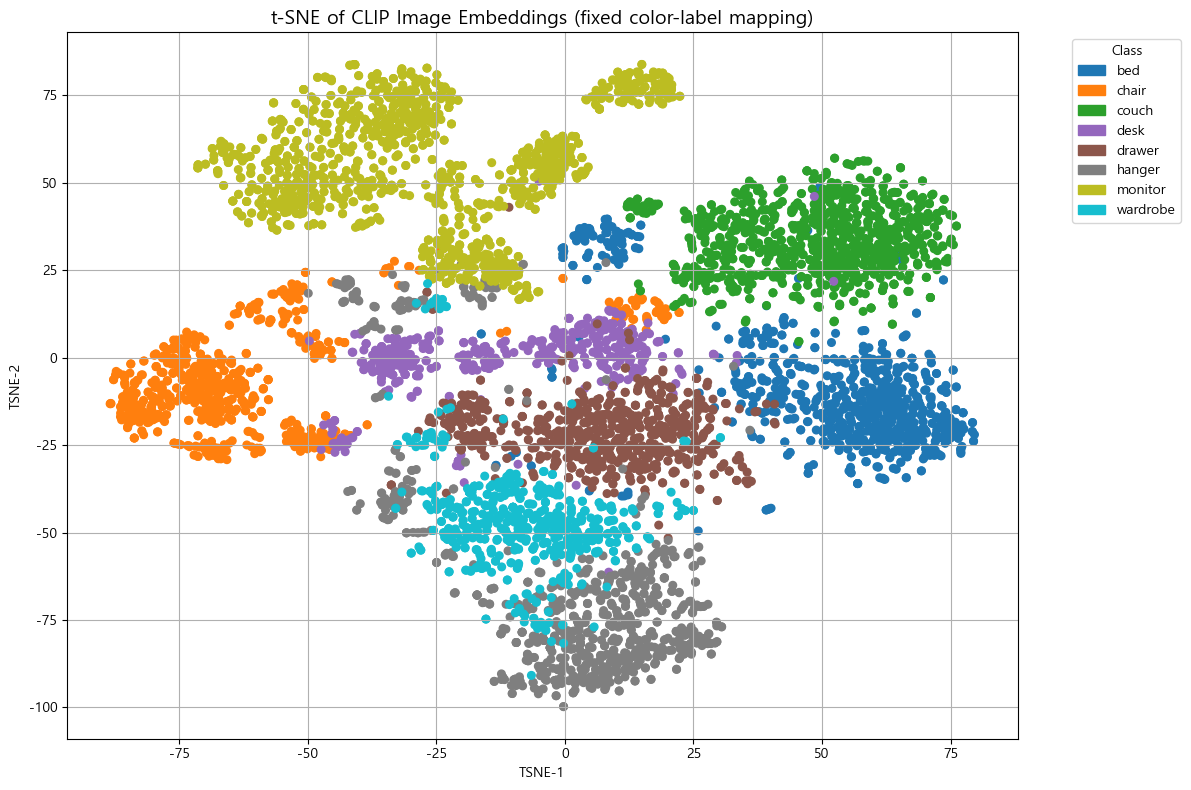

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
# ✅ 2. t-SNE 차원 축소
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(normalized_embeddings)  # shape: (7498, 2)

# ✅ 2. 고정된 색상 매핑 생성 (정렬된 클래스 기준)
unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
indexed_labels = np.array([label_to_index[lbl] for lbl in labels])

# ✅ 3. 컬러 매핑
cmap = plt.cm.get_cmap('tab10', len(unique_labels))  # 정확한 색상 수 지정

# ✅ 4. 시각화
plt.figure(figsize=(12, 8))

# 점 플롯 (컬러 인덱스 사용)
scatter = plt.scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=indexed_labels,
    cmap=cmap,
    s=30
)

# 컬러바 제거 → legend로만 구분
# plt.colorbar(scatter, ticks=range(len(unique_labels)))

# ✅ 5. 범례 수동 생성 (색상과 라벨 정확히 매핑)
from matplotlib.patches import Patch

legend_handles = [
    Patch(color=cmap(i), label=label)
    for label, i in label_to_index.items()
]

plt.legend(handles=legend_handles, title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE of CLIP Image Embeddings (fixed color-label mapping)", fontsize=14)
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.grid(True)
plt.show()

## 이상치 사진 삭제

In [ ]:
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Jupyter 대응 함수 (수정 버전)
def review_outliers_jupyter(class_label, indices, reduced, image_paths):
    class_points = reduced[indices]
    class_center = class_points.mean(axis=0)
    distances = np.linalg.norm(class_points - class_center, axis=1)
    threshold = np.percentile(distances, 99)
    outlier_local_indices = np.where(distances > threshold)[0]
    outlier_global_indices = [indices[i] for i in outlier_local_indices]

    print(f"\n🔍 Checking class: {class_label} (총 {len(indices)}개 이미지)")
    print(f" → 이상치 후보 {len(outlier_global_indices)}개")

    idx = 0

    def show_image():
        nonlocal idx
        if idx >= len(outlier_global_indices):
            print("✔️ 모든 이상치 확인 완료!")
            print("✅ 작업 완료되었습니다.")
            return

        global_idx = outlier_global_indices[idx]
        image_path = image_paths[global_idx]

        try:
            clear_output(wait=True)
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(f"Class: {class_label}\n{os.path.basename(image_path)}")
            plt.axis('off')
            plt.show()

            def on_delete(b):
                try:
                    os.remove(image_path)
                    print(f"✅ 삭제 완료: {image_path}")
                except Exception as e:
                    print(f"[삭제 오류] {e}")
                next_image(None)

            def on_keep(b):
                print("❌ 삭제하지 않음")
                next_image(None)

            def next_image(_):
                nonlocal idx
                idx += 1
                show_image()

            btn_delete = widgets.Button(description="🗑️ 삭제")
            btn_keep = widgets.Button(description="✅ 유지")

            btn_delete.on_click(on_delete)
            btn_keep.on_click(on_keep)

            display(widgets.HBox([btn_delete, btn_keep]))

        except Exception as e:
            print(f"[오류] 이미지 열기 실패: {image_path} - {e}")
            idx += 1
            show_image()

    show_image()

In [126]:
from collections import defaultdict

label_to_indices = defaultdict(list)
for i, label in enumerate(labels):
    label_to_indices[label].append(i)

In [127]:
set(labels)

{'bed', 'chair', 'couch', 'desk', 'drawer', 'hanger', 'monitor', 'wardrobe'}

In [132]:
# 예를 들어 'bed' 클래스 이상치 확인하고 싶을 때:
check_class = "desk"  # 원하는 클래스 이름으로 변경
review_outliers_jupyter(check_class, label_to_indices[check_class], reduced, image_paths)

[오류] 이미지 열기 실패: real_furniture_image_set/desk\프리메이드_이지앤_접이식_책상_750_3.jpg - [Errno 2] No such file or directory: 'real_furniture_image_set/desk\\프리메이드_이지앤_접이식_책상_750_3.jpg'
✔️ 모든 이상치 확인 완료!
✅ 작업 완료되었습니다.
